## Gender Classification

### Model - PCA and SVM

### Input - Images

In [1]:
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

In [2]:
# Read the DataFrame from the pickle file
with open('custom_dataset.pkl', 'rb') as f:
    loaded_df = pickle.load(f)

In [ ]:
# Convert the list to a 2D matrix of shape (512, 512)
loaded_df['image_front_data'] = loaded_df['image_front_data'].apply(lambda x: np.array(x).reshape(512, 512))
loaded_df['image_side_data'] = loaded_df['image_side_data'].apply(lambda x: np.array(x).reshape(512, 512))

In [ ]:
loaded_df.head()

,id,sex,bmi,image_front_data,image_side_data
0,A00360,Male,24.66,"[[185, 184, 183, 182, 181, 181, 181, 183, 183,...","[[180, 181, 183, 184, 186, 186, 185, 184, 183,..."
1,A00367,Male,33.23,"[[181, 183, 189, 191, 195, 200, 205, 209, 205,...","[[189, 191, 188, 194, 198, 197, 201, 211, 210,..."
2,A01815,Male,34.21,"[[165, 166, 169, 169, 169, 168, 166, 164, 164,...","[[172, 172, 171, 170, 170, 170, 170, 171, 171,..."
3,A01824,Male,28.48,"[[160, 154, 154, 155, 151, 149, 150, 153, 156,...","[[153, 153, 153, 154, 154, 153, 152, 151, 150,..."
4,A01889,Male,34.95,"[[149, 150, 151, 151, 151, 150, 150, 150, 149,...","[[153, 155, 155, 156, 158, 156, 154, 155, 156,..."


In [10]:
loaded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7663 entries, 0 to 7662
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7663 non-null   object 
 1   sex               7662 non-null   object 
 2   bmi               7641 non-null   float64
 3   image_front_data  7663 non-null   object 
 4   image_side_data   7663 non-null   object 
dtypes: float64(1), object(4)
memory usage: 299.5+ KB


In [16]:
# Load face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [51]:
temp = pd.DataFrame()

In [52]:
labels = []

In [53]:
temp = pd.DataFrame()
labels = []
for i in range(len(loaded_df)):
    image = loaded_df['image_front_data'].iloc[i]
    faces = detector(image)
    
    if not faces:
        print('No face detected :',loaded_df['id'].iloc[i])
        continue

    landmarks = predictor(image, faces[0])

    if not landmarks:
        print('No landmarks detected :',loaded_df['id'].iloc[i])
        continue
        
    feature = []
    for coord in range(68):
        x_coord = landmarks.part(coord).x
        y_coord = landmarks.part(coord).y
        feature.append(x_coord)
        feature.append(y_coord)
        
    temp = pd.concat([temp, pd.DataFrame([feature])], ignore_index=True)
    if(loaded_df['sex'].iloc[i] == 'Male'):
        labels.append(0)
    else:
        labels.append(1)

No face detected : A10508
No face detected : A10938
No face detected : A80442
No face detected : A91250
No face detected : B03186
No face detected : B04516
No face detected : B09533
No face detected : B25658
No face detected : B38219
No face detected : B84769
No face detected : K74649
No face detected : M47760
No face detected : N10255
No face detected : N23774
No face detected : N62045
No face detected : N63220
No face detected : N82954
No face detected : N90809
No face detected : N93177
No face detected : N98608
No face detected : R23770
No face detected : R60484
No face detected : R68950
No face detected : Y10340
No face detected : Y22814


In [54]:
labels.count(0), labels.count(1)

(3976, 3662)

In [55]:
temp.head()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,133,188,134,218,137,248,139,277,144,306,...,239,307,268,311,239,309,228,310,218,308
1,133,217,137,243,142,270,149,297,160,322,...,257,292,279,290,257,289,248,292,237,293
2,146,163,144,184,143,206,143,229,147,251,...,238,226,257,232,238,226,228,227,219,226
3,133,188,134,217,138,245,144,275,153,302,...,252,301,273,297,253,301,241,304,228,302
4,156,238,154,263,154,291,157,320,164,348,...,260,309,297,320,261,324,247,325,233,324


In [56]:
temp.shape

(7638, 136)

In [67]:
def PCA(dataset):
    mean = np.mean(dataset, axis=0)
    z = dataset - mean
    cov_matrix = (1/len(dataset)) * (z.T).dot(z)
    eig_values, eig_vectors = np.linalg.eig(cov_matrix)
    eig_pairs = [(eig_values[i], eig_vectors[:,i]) for i in range(len(eig_values))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)

    sorted_eigvalues = [eig_pairs[i][0] for i in range(len(eig_values))]
    sorted_eigvectors = np.array([eig_pairs[i][1] for i in range(len(eig_values))])

    cumulative_variance = np.cumsum(sorted_eigvalues) / np.sum(sorted_eigvalues)
    plt.plot(cumulative_variance)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance')
    plt.title('Cumulative Variance vs Number of Principal Components')
    plt.show()

    n_components = np.argmax(cumulative_variance > 0.999) + 1

    print('Number of Principal Components required:', n_components)

    W = sorted_eigvectors[:, :n_components]
    print('Shape of W:', W.shape)

    dataset_pca = z.dot(W)
    print('Shape of Reduced Dataset:', dataset_pca.shape)
    return W, dataset_pca, mean

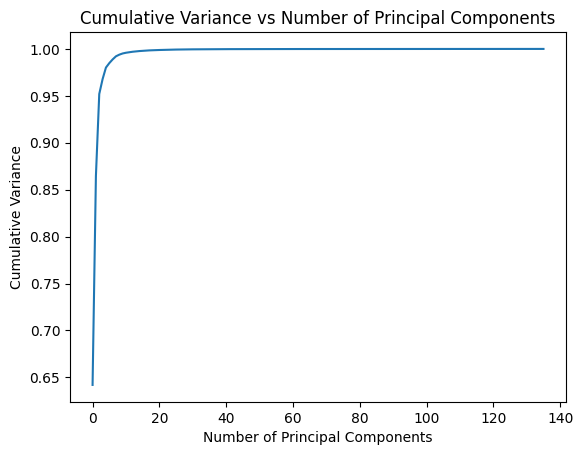

Number of Principal Components required: 8
Shape of W: (136, 20)
Shape of Reduced Dataset: (7638, 20)


In [68]:
W, dataset_reduced, mean = PCA(np.array(temp))

In [ ]:
# perform svm on the reduced dataset and labels

X_train, X_test, y_train, y_test = train_test_split(dataset_reduced, labels, test_size=0.1, random_state=42)

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

In [66]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.preprocessing import StandardScaler

# Ensure labels are in the form {-1, 1}
def adjust_labels(y):
    return 2 * y - 1  # Convert 0 to -1, keep 1 as 1

def getalpha(x, y, max_iters=1000, abstol=1e-7, reltol=1e-7, feastol=1e-7):
    m, n = x.shape

    # Reshape y to a column vector
    y = y.reshape(-1, 1)

    # Compute the Gram matrix H
    H = (y @ y.T) * (x @ x.T)
    H = np.array(H, dtype='double')  # Ensure H is double type

    # Convert to cvxopt matrix
    P = matrix(H)
    q = matrix(-np.ones((m, 1), dtype='double'))
    G = matrix(-np.eye(m))  # G = -I
    h = matrix(np.zeros((m, 1), dtype='double'))
    A = matrix(y.T, (1, m), 'd')
    b = matrix(0.0)

    # Solver options
    solvers.options['show_progress'] = False  # Suppress solver output
    solvers.options['maxiters'] = 1000  # Maximum iterations

    # Solve the quadratic programming problem
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x']).flatten()
    return alphas

def train_svm(x_train, y_train, max_iters=1000):
    x = np.array(x_train)
    y = np.array(y_train)

    # Ensure labels are in the correct format (-1, 1)
    y = adjust_labels(y)

    # Compute alpha values
    alphas = getalpha(x, y, max_iters)

    # Identify support vectors
    tol = 1e-4
    support_indices = alphas > tol
    support_vectors = x[support_indices]
    support_labels = y[support_indices].flatten()
    support_alphas = alphas[support_indices]

    # Calculate weights
    w = np.sum((support_alphas * support_labels).reshape(-1, 1) * support_vectors, axis=0)

    # Calculate bias
    b = np.mean(support_labels - np.dot(support_vectors, w))

    return w, b, support_vectors, support_labels, support_alphas

def predict_svm(x_test, w, b):
    return np.sign(np.dot(x_test, w) + b)

def evaluate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

# Example Usage
if __name__ == "__main__":

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the SVM
    w, b, support_vectors, support_labels, support_alphas = train_svm(X_train[:1600], y_train[:1600])

    # Test the SVM
    y_pred = predict_svm(X_test[:200], w, b)

    # Evaluate Performance
    accuracy = evaluate_accuracy(y_test[:200], y_pred)
    print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 0.9554973821989529
